In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models,layers

In [9]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [10]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [11]:
class_names=dataset.class_names

In [12]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [13]:
len(dataset)

68

In [14]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy().shape)

(32, 256, 256, 3)
(32,)


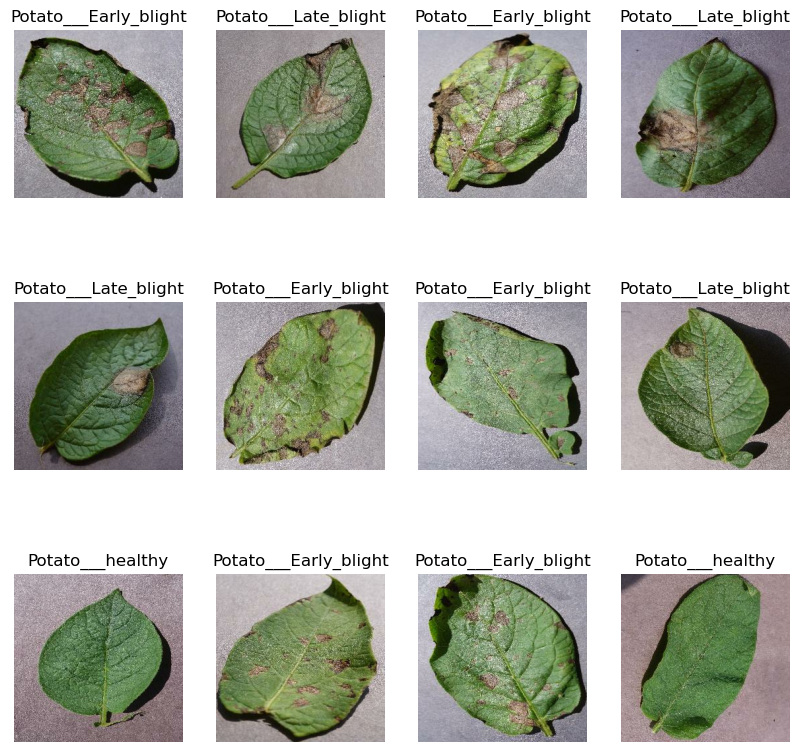

In [15]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
   for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [16]:
len(dataset)

68

In [17]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [18]:
train_ds=dataset.take(54)
test_ds=dataset.skip(54)
val_size=0.1
print(len(dataset)*val_size)
val_ds=test_ds.take(6)
test_ds=test_ds.skip(6)
print(len(test_ds))

6.800000000000001
8


In [19]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    params={
        "train_ds":train_ds,
        "val_ds":val_ds,
        "test_ds":test_ds
    }

    return params

In [20]:
params=get_dataset_partitions_tf(dataset)

In [21]:
for key in params:
    length=len(params[key])
    print(f"the {key} has a length of : {length}")

the train_ds has a length of : 54
the val_ds has a length of : 6
the test_ds has a length of : 8


In [22]:
for key in params:
    params[key]=params[key].cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
resize_and_scale=tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
        layers.experimental.preprocessing.Rescaling(1./255)
    ]
)

In [24]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)

])

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_scale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [28]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [29]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 264s 5s/step - loss: 0.8395 - accuracy: 0.5608 - val_loss: 0.6484 - val_accuracy: 0.7031
Epoch 2/50
54/54 [==============================] - 218s 4s/step - loss: 0.4895 - accuracy: 0.7888 - val_loss: 0.2792 - val_accuracy: 0.8958
Epoch 3/50
54/54 [==============================] - 226s 4s/step - loss: 0.3176 - accuracy: 0.8675 - val_loss: 0.2355 - val_accuracy: 0.9115
Epoch 4/50
54/54 [==============================] - 238s 4s/step - loss: 0.2854 - accuracy: 0.8825 - val_loss: 0.1909 - val_accuracy: 0.9219
Epoch 5/50
46/54 [========================>.....] - ETA: 31s - loss: 0.2229 - accuracy: 0.9212

KeyboardInterrupt: 

In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()